# NER - Multilang

In [1]:
import numpy as np
import pandas as pd
import csv
import pickle
import keras
from sklearn_crfsuite import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF

# Mainly Used:
# https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/

Using TensorFlow backend.


### Prepare data files

In [2]:
def sweStandardizeTag(line):
    SWE_TAG_SET=["ORG","PRS","LOC","OTHER","O"]
    lineParts = line.split("\t")
    ner_tag = lineParts[2]
    if ner_tag in SWE_TAG_SET:
        return line
    if ner_tag[:3] == "LOC" or ner_tag == "place":
        ner_tag = "LOC"
    if ner_tag == "person":
        ner_tag = "PRS"
    if ner_tag in ["inst", "ORG/PRS", "OBJ/ORG"]:
        ner_tag = "ORG"
    if ner_tag in ["WRK","OBJ","EVN","product","other","work","event","myth","animal","MSR","TME","PRS/WRK"]:
        ner_tag = "OTHER"
    
    if ner_tag not in SWE_TAG_SET:
        raise Exception(ner_tag + " - not in tag set") 
    return lineParts[0] + "\t" + lineParts[1] + "\t" + ner_tag

def engStandardizeTag(line):
    ENG_TAG_SET=["ORG","PRS","LOC","OTHER","O"]
    lineParts = line.split("\t")
    ner_tag = lineParts[2]
    ner_tag = ner_tag.strip()
    if ner_tag[-3:] == "geo":
        ner_tag = "LOC"
    if ner_tag[-3:] == "per":
        ner_tag = "PRS"
    if ner_tag in ["B-org", "I-org"]:
        ner_tag = "ORG"
    if ner_tag in ["B-gpe","CD","B-tim","B-art","I-art","I-gpe","I-tim","B-nat","I-nat",
                  "B-eve","I-eve"]:
        ner_tag = "OTHER"
    if ner_tag in ["000\"","00","\"","JJ","NNS","CC"] or ner_tag[:2].isdigit():
        return ""
    
    if ner_tag not in ENG_TAG_SET:
        raise Exception(ner_tag + " - not in tag set") 
    return lineParts[0].strip() + "\t" + lineParts[1].strip() + "\t" + ner_tag

def frStandardizeTag(line):
    SWE_TAG_SET=["ORG","PRS","LOC","OTHER","O"]
    lineParts = line.split("\t")
    ner_tag = lineParts[2]
    if ner_tag in SWE_TAG_SET:
        return line
    if ner_tag[-3:] == "LOC" or ner_tag == "place":
        ner_tag = "LOC"
    if ner_tag[-3:] == "PER" or ner_tag == "person":
        ner_tag = "PRS"
    if ner_tag[-3:] == "ORG":
        ner_tag = "ORG"
    if ner_tag in ["I-MISC","B-MISC"]:
        ner_tag = "OTHER"
    
    if ner_tag not in SWE_TAG_SET:
        raise Exception(ner_tag + " - not in tag set") 
    return lineParts[0] + "\t" + lineParts[1] + "\t" + ner_tag


DATA_DIR="../../DATA"
filenames = [ "swedish.txt", "english.txt", "french.txt"]

for langID in range(len(filenames)):
    filename=filenames[langID]
    originalFile= open(DATA_DIR + "/" + filename,"r")
    file= open(DATA_DIR + "/sent_" + filename,"w+")
    originalFileLines =originalFile.readlines()
    sentId=1
    for line in originalFileLines:
        line = line.strip()
        if len(line) == 0:
            sentId = sentId + 1
            continue
        if langID == 0:
            line = sweStandardizeTag(line)
        if langID ==1:
            line = engStandardizeTag(line)
        if langID ==2:
            line = frStandardizeTag(line)
        
        if len(line) == 0:
            sentId = sentId + 1
            continue
        file.write(str(sentId) + "\t" + line +"\n")
    file.close()
    originalFile.close()
print("done")

done


#### Read and Analyse Data

In [3]:
DATA_DIR="../../DATA"
SENT_COL="sent"
TOKEN_COL="token"
SHAPE_COL="token_shape"
POS_COL="pos"
NER_COL="ner"

TOKEN_SHAPE_CAT_COL="token_shape_cat"
POS_CAT_COL="pos_cat"
POS_PREV_CAT_COL="pos_prev_cat"
POS_NEXT_CAT_COL="pos_next_cat"
POS_PREV_PREV_CAT_COL="pos_prev_prev_cat"
NER_CAT_COL="ner_cat"

filenames = [ "sent_swedish.txt", "sent_english.txt", "sent_french.txt"]

swe_data = pd.read_csv( DATA_DIR + '/' + filenames[0], sep="\t", header=None, quoting=csv.QUOTE_NONE)
eng_data = pd.read_csv( DATA_DIR + '/' + filenames[1], sep="\t", header=None, quoting=csv.QUOTE_NONE)
fr_data = pd.read_csv( DATA_DIR + '/' + filenames[2], sep="\t", header=None, quoting=csv.QUOTE_NONE)

def analyseTokens(df):
    new_token_col = []
    for token in df[TOKEN_COL]:
        token=token.strip()
        token_shape = ""
        if len(token) == 1 and not token.isalnum():
            token_shape = "sign" # or =token
        else:
            if token.isupper():
                token_shape="X"
            elif token[0].isupper():
                token_shape="Xx"
            else:
                token_shape="x"
            if token[len(token)-1] == ".":
                token_shape+="."
        new_token_col.append(token_shape)
    df[SHAPE_COL]=new_token_col

def offsetArray(array,offset):
    return np.roll(array,offset)
    
dataframes = [ swe_data, eng_data, fr_data ]

for df in dataframes:
    df.columns = [ SENT_COL, TOKEN_COL, POS_COL, NER_COL ]
    analyseTokens(df)

DATA_TESTED = eng_data

DATA_TESTED.head()

,sent,token,pos,ner,token_shape
0,1,Thousands,NNS,O,Xx
1,1,of,IN,O,x
2,1,demonstrators,NNS,O,x
3,1,have,VBP,O,x
4,1,marched,VBN,O,x


### Extract features

In [4]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t,s) for w, p, t,s in zip(s[TOKEN_COL].values.tolist(),
                                                           s[POS_COL].values.tolist(),
                                                           s[NER_COL].values.tolist(),
                                                           s[SHAPE_COL].values.tolist())]
        self.grouped = self.data.groupby(SENT_COL).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    shapetag = sent[i][3]
    

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'shapetag': shapetag,
        'shapetag[:2]': shapetag,
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        shapetag1 = sent[i-1][3]
        
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:shapetag': shapetag1,
            '-1:shapetag[:2]': shapetag1[:2],
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        shapetag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
             '+1:shapetag': shapetag1,
            '+1:shapetag[:2]': shapetag1[:2],
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label, shape in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

getter = SentenceGetter(DATA_TESTED)
sentences = getter.sentences

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

print("done")

done


#### Visualize Sentences

Number of sentences: 81134


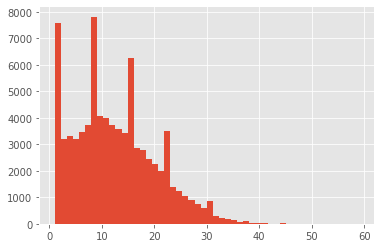

max len:  59


In [5]:
getter = SentenceGetter(DATA_TESTED)
sentences = getter.sentences
print("Number of sentences: " +str(len(sentences)))

plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

print("max len: ",max([len(s) for s in sentences]))

#### Split Data into Train/Test

In [6]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.1)
print("Done, Train length:" + str(len(xTrain)) + " Test length: " + str(len(xTest)))

Done, Train length:73020 Test length: 8114



#### Train Model

In [7]:
crf = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

print("Training")
crf.fit(xTrain, yTrain)
print("Done")

Training
Done


#### Test Accuracy

In [8]:
# https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
labels = list(crf.classes_)
labels.remove('O')
print("Labels:" + str(labels))

y_pred = crf.predict(xTest)

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    yTest, y_pred, labels=sorted_labels, digits=3
))

Labels:['LOC', 'PRS', 'OTHER', 'ORG']
              precision    recall  f1-score   support

         LOC      0.830     0.887     0.857      4548
         ORG      0.763     0.732     0.747      3666
         PRS      0.823     0.861     0.841      3277
       OTHER      0.943     0.825     0.880      4586

   micro avg      0.842     0.828     0.835     16077
   macro avg      0.840     0.826     0.831     16077
weighted avg      0.845     0.828     0.835     16077



#### Save Model

In [17]:
#https://github.com/floydhub/named-entity-recognition-template/blob/master/ner.ipynb
filename=""
# filename="crf_swe.pickle"
# filename="crf_eng.pickle"
# filename="crf_fr.pickle"

with open('model/' + filename, 'wb') as handle:
   pickle.dump(crf, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved " + filename)

Saved crf_fr.pickle


#### Load Model

In [48]:
filenameload=""
# filenameload="crf_swe.pickle"
# filenameload="crf_eng.pickle"
# filenameload="crf_fr.pickle"

file = open('model/' + filenameload, 'rb')
crf = pickle.load(file)
file.close()

print("Loaded " + filenameload)

Loaded crf_fr.pickle
